In [1]:
#[220505_1137]UPDATED 지금까지 구성을 전부 정리함
from Bio import Entrez
from Bio import SeqIO
from Bio.Align.Applications import MuscleCommandline
from pathlib import Path

Entrez.email = "nagabuti13@naver.com"

#[220502_1717]CREATED getIdList: NCBI에서 keyword를 검색하여 script의 id를 추출한다
#[220512_1210]NOTED esearch()의 파라미터에 id의 개수를 조절하는 retmax 파라미터가 존재
def getIdlist(database, keyword):
    handle = Entrez.esearch(db = database, retmax = 30, term = keyword)
    records = Entrez.read(handle)
    return records["IdList"]

#[220505_1717]CREATED getFastaFile: NCBI에서 id를 검색하여 얻은 fasta파일을 컴퓨터에 저장한다
def getFasta(id):
    handle = Entrez.efetch(db = 'nucleotide', id = id, rettype = 'fasta', retmode = 'text')
    record = SeqIO.read(handle, 'fasta')
    print('## creating ' + record.id + '.fasta...')
    with open(record.id + '.fasta', 'w') as f:
        f.write('>' + record.description + '\n')
        f.write(str(record.seq) + '\n')
    
#[220502_1717]CREATED getAlnFile: 다중염기서열을 생성하는 툴 중 하나인 MUSCLE로 aln파일을 생성한다
def getAln(filename):
    muscle_exe = '/Users/biosmu/muscle3.8.31_i86darwin64'
    cmd_line = MuscleCommandline(muscle_exe, input = filename,
                             out = Path(filename).stem + '.aln', clw = ' ')
    print(cmd_line)
    stdout, stderr = cmd_line()   

## 원본과 예측값 비교를 위한 시각화 

In [9]:
getAln('all_mammalia_coi.fasta')

/Users/biosmu/muscle3.8.31_i86darwin64 -in all_mammalia_coi.fasta -out all_mammalia_coi.aln -clw


## 데이터 전처리 및 DataFrame 구성

* DataFrame의 Target 구성을 위해 종(species) 크롤링 

In [2]:
from Bio import SeqIO
from Bio import Entrez
from Bio import GenBank

Entrez.email = "nagabuti13@naver.com"

#[220509_1517]CREATED ncbi에서 alignment의 각 record genbank파일로부터 종 이름을 반환
def getGenbank(id):
    handle = Entrez.efetch(db = "nucleotide", rettype = "gb", id = id, retmode = "text")
    r = GenBank.read(handle)
    return r

In [11]:
from Bio import AlignIO
import pandas as pd

alignment = AlignIO.read('all_mammalia_coi.aln', 'clustal')
sum_s, sum_e = 0, 0
length = []
count = 0
start, end = 0, 0
k = 3
mer = ''
for record in alignment:
    count = 0
    for i in range(len(record.seq)):
        mer = record.seq[i:i + k]
        if(count == 1 and mer.count('-') == 2):
            end = i
            break
        elif(mer.count('-') == 3):
            continue
        elif(count != 1):
            start = i + k - 1
            count = 1
        #print(start, end)
    length.append(end - start + 1)
length.sort()
pd.DataFrame(length).value_counts()
    #sum_s += start
    #sum_e += end
#print('Mean Length of Alingment: {0}, Mean Start of Alignment: {1}, Mean End of Alingment: {2}'.format(int(sum_s / len(alignment)), int(sum_e / len(alignment)), int(sum_e / len(alignment)) - int(sum_s / len(alignment))))


151    46
150    45
171    35
0      25
164    24
165     5
141     5
196     4
159     4
148     4
138     4
4       4
131     4
125     2
130     2
132     2
120     2
74      2
122     1
9       1
195     1
177     1
41      1
167     1
44      1
51      1
156     1
153     1
75      1
99      1
105     1
146     1
143     1
107     1
109     1
135     1
111     1
113     1
117     1
388     1
dtype: int64

* DataFrame의 열(feature) 구성을 위해 k-mer(k = 3)을 활용

In [3]:
#[220508_1659]CREATED Sequecne Alignment를 다룰 수 있는 모듈 호출
from Bio import AlignIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans

alignment = AlignIO.read('all_mammalia_coi.aln', 'clustal')

k = 3
dict = {}
df = pd.DataFrame()
#[220513_1700]CREATED AGCT 외의 염기를 처리하기 위해 사전형에 key, value로 저장 
base_dict = {'A':'A', 'G':'G', 'C':'C', 'T':'T', 'U':'U',
'Y':'T', 'R':'A', 'S':'C', 'W':'A', 'K':'G', 'M':'C', 'B':'C', 'D':'G', 'H':'T', 'V':'C', 'N':'A'}

#[220508_1735]CREATED k = 3인 kmer의 모든 경우의 수를 사전형에 미리 저장
def init(datatype):
    for i in range(4):
        for j in range(4):
            for k in range(4):
                datatype[list(base_dict.keys())[i] + list(base_dict.keys())[j] + list(base_dict.keys())[k]] = 0
    #datatype['---'] = 0
    #[220509_1517]CREATED k-means는 unsupervised이지만, 여기서는 표본의 타겟을 ncbi에서부터 추출가능하므로 타겟 피처 생성
    datatype['target'] = 0

init(df)

#[220508_1738]CREATED 'all.aln' 안의 모든 개체의 염기서열을 k = 3인 kmers로 구분짓고 빈도를 사전에 저장
for i, record in enumerate(alignment):
    init(dict)
    #[220509_1517]NOTED getOrganism() 호출
    dict['target'] = getGenbank(record.id).organism
    index = 0
    if(len(record.seq[48:198]) >= k):
        while(index + k <= 150):
            mer = record.seq[48:198][index:index + k]
            if(mer.find('-') != -1):
                #dict['---'] += 1
                index += 1
                continue
            #[220513_1810]CREATED kmer 문자열을 base_dict의 values로 교체
            for p in range(k):
                mer = mer.replace(mer[p], base_dict.get(mer[p]))
                
            dict[mer] += 1
            index += 1
    df.loc[i] = dict
    
#[220508_2232]NOTED 총 문자열 길이를 L이라 하면, kmers의 개수: L - k + 1 ex) 1542 - 3 + 1 = 1540개
#[220513_1623]NOTED 1542 -> 17377(하나의 시퀀스의 실제 길이: 약 600bp이지만 MSA의 경우 '-'로 인해 길어져 보인다.)

In [5]:
df

,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TGT,TCA,TCG,TCC,TCT,TTA,TTG,TTC,TTT,target
0,5,5,2,3,3,2,3,0,3,0,...,2,4,1,1,3,4,2,3,7,Mus musculus
1,1,0,2,5,0,1,1,2,0,2,...,2,3,1,1,3,2,1,0,2,Panthera tigris
2,1,0,2,4,1,1,1,4,1,0,...,2,2,1,1,2,4,2,1,6,Panthera tigris
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Panthera tigris
4,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,Panthera tigris
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,0,0,3,6,3,3,5,1,1,0,...,3,2,1,0,4,4,5,3,3,Tamias sibiricus
237,0,0,3,6,3,3,5,1,1,0,...,3,2,1,0,1,4,4,2,2,Tamias sibiricus
238,1,0,3,6,2,2,5,1,1,0,...,2,0,2,0,0,4,2,2,1,Tamias sibiricus
239,1,0,3,6,2,2,5,1,1,0,...,2,0,2,0,0,4,2,2,1,Tamias sibiricus


In [6]:
#[220509_1621]CREATED 레이블 인코딩으로 종 이름 -> 고유 숫자
from sklearn.preprocessing import LabelEncoder

a = df['target']
encoder = LabelEncoder()
labels = encoder.fit_transform(a)
#[220509_1622]NOTED* 종의 총 개수 = 19인 것을 알 수 있으므로 KMeans의 파라미터인 n_clusters를 14 -> 19로 수정
#[220513_1830]NOTED 종: 101개
#[220519_1745]NOTED 종: 9개
print(labels)

df['target'] = labels
df.head()

[2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 0 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 1 1 1 1 1 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 4 4 4 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]


,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TGT,TCA,TCG,TCC,TCT,TTA,TTG,TTC,TTT,target
0,5,5,2,3,3,2,3,0,3,0,...,2,4,1,1,3,4,2,3,7,2
1,1,0,2,5,0,1,1,2,0,2,...,2,3,1,1,3,2,1,0,2,3
2,1,0,2,4,1,1,1,4,1,0,...,2,2,1,1,2,4,2,1,6,3
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
4,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,3


### LDA 차원축소 사용했을 때

In [7]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components = 2)
lda.fit(df.loc[:, :'TTT'], df['target'])
ma_lda = lda.transform(df.loc[:, :'TTT'])
print(ma_lda.shape)

df['lda_x'] = ma_lda[:, 0]
df['lda_y'] = ma_lda[:, 1]
df.head()

(241, 2)


,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TCG,TCC,TCT,TTA,TTG,TTC,TTT,target,lda_x,lda_y
0,5,5,2,3,3,2,3,0,3,0,...,1,1,3,4,2,3,7,2,-34.505971,-18.598665
1,1,0,2,5,0,1,1,2,0,2,...,1,1,3,2,1,0,2,3,-28.158164,26.914322
2,1,0,2,4,1,1,1,4,1,0,...,1,1,2,4,2,1,6,3,-28.414656,26.035782
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,-31.889283,27.651349
4,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,1,0,1,3,-28.110256,26.438953


In [8]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average = 'macro')
    recall = recall_score(y_test, pred, average = 'macro')
    
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.2f}, 정밀도: {1:.2f}, 재현율: {2:.2f}'.format(accuracy, precision, recall))
    
    
svm_2 = SVC(kernel = 'linear') 
#[220715_1739]NOTED 모델 생성

X = df[['lda_x', 'lda_y']]
y = df['target']

scaler = StandardScaler()
new_X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size = 0.2)
#[220715_1740]NOTED 학습 데이터와 테스트 데이어셋으로 무작위 분리한 뒤 정규화

parameters = {'C':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'gamma':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
#[220715_1741]NOTED 파라미터 후보 설정

grid_svm = GridSearchCV(svm_2, param_grid = parameters, cv = 5)
grid_svm.fit(X_train, y_train)  
#[220711_1658]NOTED 검증 데이터셋 + 학습 데이터셋 = 원래 학습 데이터셋

print(grid_svm.best_params_)
print(grid_svm.best_score_)
best_pred = grid_svm.best_estimator_.predict(X_test)
get_clf_eval(y_test, best_pred)

/Users/biosmu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


{'C': 1, 'gamma': 1}
0.9897435897435898
오차 행렬
[[ 6  0  0  0  0  0]
 [ 0  2  0  0  0  0]
 [ 0  0 24  0  0  0]
 [ 0  0  0  9  0  0]
 [ 0  0  0  0  1  0]
 [ 0  0  0  0  0  7]]
정확도: 1.00, 정밀도: 1.00, 재현율: 1.00


### t-sne 차원축소 사용했을 때

In [26]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2, perplexity = 30).fit_transform(df.loc[:,:'TTT'])

df['tsne_x'] = tsne[:, 0]
df['tsne_y'] = tsne[:, 1]
df.head()

/Users/biosmu/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/biosmu/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TTA,TTG,TTC,TTT,target,lda_x,lda_y,cluster,tsne_x,tsne_y
0,5,5,2,3,3,2,3,0,3,0,...,4,2,3,7,2,-34.505971,-18.598665,0,-5.341811,2.578855
1,1,0,2,5,0,1,1,2,0,2,...,2,1,0,2,3,-28.158164,26.914322,5,-5.282844,-6.477275
2,1,0,2,4,1,1,1,4,1,0,...,4,2,1,6,3,-28.414656,26.035782,5,-3.394489,6.417227
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,3,-31.889283,27.651349,5,-16.692467,-7.371946
4,0,0,0,2,0,0,0,0,0,0,...,0,1,0,1,3,-28.110256,26.438953,5,-16.349632,-8.464453


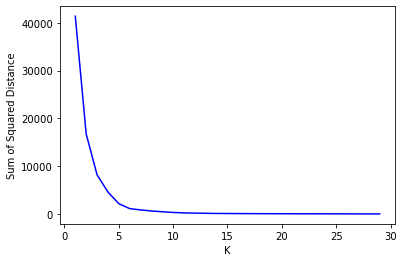

In [27]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

ks = range(1, 30)
sse = []
for k in ks:
    km = KMeans(n_clusters = k, max_iter = 1000)
    km.fit(df[['tsne_x', 'tsne_y']])
    sse.append(km.inertia_)

plt.plot(ks, sse, 'b')
plt.xlabel('K')
plt.ylabel('Sum of Squared Distance')
plt.show()
#[220805_1649]CREATED k = 6일 때가 최적 but 실제는 9

In [28]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np

ks = range(2, 20)
for k in ks:
    kmeans = KMeans(n_clusters = k, max_iter=500)
    kmeans.fit(df[['tsne_x', 'tsne_y']])
    df['cluster'] = kmeans.labels_
    df['sil_sam'] = silhouette_samples(df[['tsne_x', 'tsne_y']], df['cluster'])
    sil_tot = silhouette_score(df[['tsne_x', 'tsne_y']], df['cluster'])
    sil_clu = df.groupby('cluster')['sil_sam'].mean()
    score_k = np.mean([abs(i - sil_tot) for i in sil_clu])
    print('전체 실루엣 계수 평균: {0:.3f}\n군집 별 실루엣 계수 평균: \n{1}'.format(sil_tot, sil_clu))
    print('score: {0:.3f}'.format(score_k))
    print('---------------')
    df.drop('cluster', axis = 1, inplace = True)
    df.drop('sil_sam', axis = 1, inplace = True)
#[220801_1637]CREATED 전체 실루엣 계수 평균이 높으면서 군집 별 실루엣 계수와 크게 차이나지 않는 k 값은 9이다.

전체 실루엣 계수 평균: 0.572
군집 별 실루엣 계수 평균: 
cluster
0    0.652262
1    0.436249
Name: sil_sam, dtype: float32
score: 0.108
---------------
전체 실루엣 계수 평균: 0.642
군집 별 실루엣 계수 평균: 
cluster
0    0.621826
1    0.957475
2    0.582806
Name: sil_sam, dtype: float32
score: 0.132
---------------
전체 실루엣 계수 평균: 0.623
군집 별 실루엣 계수 평균: 
cluster
0    0.487720
1    0.957475
2    0.554144
3    0.673298
Name: sil_sam, dtype: float32
score: 0.147
---------------
전체 실루엣 계수 평균: 0.699
군집 별 실루엣 계수 평균: 
cluster
0    0.485598
1    0.959896
2    0.926419
3    0.659443
4    0.687480
Name: sil_sam, dtype: float32
score: 0.150
---------------
전체 실루엣 계수 평균: 0.756
군집 별 실루엣 계수 평균: 
cluster
0    0.912353
1    0.644615
2    0.947401
3    0.743584
4    0.605081
5    0.898190
Name: sil_sam, dtype: float32
score: 0.127
---------------
전체 실루엣 계수 평균: 0.733
군집 별 실루엣 계수 평균: 
cluster
0    0.484551
1    0.912353
2    0.947401
3    0.599402
4    0.898190
5    0.738394
6    0.998158
Name: sil_sam, dtype: float32
score: 0.173
--------------

In [29]:
km = KMeans(n_clusters = 10, max_iter = 1000)
km.fit(df[['tsne_x', 'tsne_y']])
df['cluster'] = km.labels_
cal_accuracy(df['target'], df['cluster'])

0.9024872544609386

In [30]:
ct = pd.crosstab(df['target'], df['cluster'])
ct

cluster,0,1,2,3,4,5,6,7,8,9
target,,,,,,,,,,
0,0,0,0,5,0,21,0,0,0,0
1,0,0,0,0,0,0,0,0,7,0
2,35,0,43,0,1,0,13,10,0,12
3,0,0,0,30,0,1,0,0,1,0
4,0,0,0,0,0,0,0,0,3,0
5,0,0,0,0,0,0,0,0,2,0
6,0,0,0,0,24,0,0,0,0,0
7,0,0,0,0,0,0,0,0,1,0
8,0,32,0,0,0,0,0,0,0,0


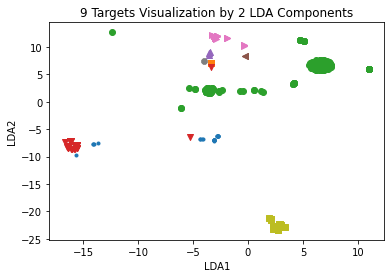

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

marker_ind = []
for i in range(9):
    marker_ind.append(df[df['target'] == i].index)
marker = ['.', ',', 'o', 'v', '^', '<', '>', '8', 's', 'p']
for i, j in zip(marker, marker_ind):
    plt.scatter(x = df.loc[j, 'tsne_x'], y = df.loc[j, 'tsne_y'], marker = i)

plt.xlabel('LDA1')
plt.ylabel('LDA2')
plt.title('9 Targets Visualization by 2 LDA Components')
plt.show()

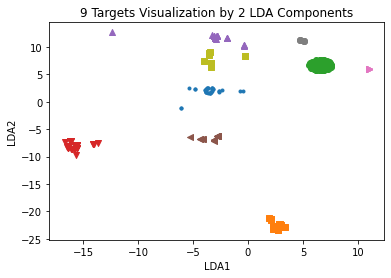

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

marker_ind = []
for i in range(9):
    marker_ind.append(df[df['cluster'] == i].index)
marker = ['.', ',', 'o', 'v', '^', '<', '>', '8', 's', 'p']
for i, j in zip(marker, marker_ind):
    plt.scatter(x = df.loc[j, 'tsne_x'], y = df.loc[j, 'tsne_y'], marker = i)

plt.xlabel('LDA1')
plt.ylabel('LDA2')
plt.title('9 Targets Visualization by 2 LDA Components')
plt.show()

In [44]:
km2 = KMeans(n_clusters = 10, max_iter = 1000)
km2.fit(df[['tsne_x', 'tsne_y']])
cal_accuracy(df['target'], km2.labels_)

0.9024872544609386